<a href="https://colab.research.google.com/github/climatechange-ai-tutorials/tracking-ml-emissions/blob/main/Tracking_Emissions_from_ML_Models_(Revised_with_exercises).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Track Emissions when Training Machine Learning Models
**Content Creator**: Mel Hanna (mdriscollhanna@gmail.com)

Welcome to CCAI's tutorial on tracking and mitigating the emissions from ML model training!

In order to make edits to this notebook, you should press **File > "Save a Copy in Drive"**. This will ensure that any edits will be on your local copy, and they will not affect the notebook shared with everyone else.

# Table of Contents


*   [Overview](#overview)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Climate Impact](#climate-impact)
*   [Methodology](#methodology)
*   [Results & Discussion](#codecarbon-experiments)
*   [References](#references)

<a name="overview"></a>
# Overview
This tutorial explains the methodology behind calculating computing-related GHG emissions from training machine learning models and demonstrates some strategies to reduce a model's carbon footprint.

Specifically, you will learn how to:
- measure a ML model's emissions with CodeCarbon
- potentially reduce a ML model's carbon footprint during training




<a name="target-audience"></a>
## **Target Audience**
This tutorial is intended for experienced and aspiring data scientists looking for concrete examples of how to track carbon emissions while executing code and how to train machine learning models in a more efficient way. The reader should understand the basic mechanics of training an ML model, such as splitting data between train and test sets and tuning hyperparameters.

<a name="software-requirements"></a>
## **Software Requirements**

This notebook requires Python >= 3.7. The following libraries are required:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

### **Enabling GPU in Google Colab**
Before we start, you will need access to a GPU.  Fortunately, Google Colab provides free access to computing resources including GPUs. The GPUs currently available in Colab include Nvidia K80s, T4s, P4s and P100s. Unfortunately, there is no way to choose what type of GPU you can connect to in Colab. [See here for information](https://research.google.com/colaboratory/faq.html#gpu-availability).

To enable GPU in Google Colab:
1. Navigate to Edit→Notebook Settings or Runtime→Change Runtime Type.
2. Select GPU from the Hardware Accelerator drop-down.

### **Other dependencies**

We'll also take a moment to install and import the necessary dependencies for executing the rest of the notebook.

In [ ]:
%%bash
pip install codecarbon
pip install dash
pip install dash-bootstrap-components==0.13.1
pip install netCDF4
pip install fire
pip install optuna

mkdir code_carbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.9/494.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.3/197.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=e41a7c2c43c8341cdfec4a44a995f79103b21b93a6a7b4fd85c89dc25f8936a7
  Stored in directory: /roo

In [ ]:
%matplotlib inline
import random

import numpy as np
import optuna
import pandas as pd
import scipy.stats
import sklearn
import sklearn.ensemble
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import xarray as xr
from codecarbon import EmissionsTracker
from google.colab.output import eval_js
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Set seeds for reproducibility
# Per PyTorch, results may not be reproducible between CPU and GPU executions,
# even when using identical seeds
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

<a name="climate-impact"></a>
# **1. Climate Impact of Machine Learning**

Machine learning models can have a wide-ranging and potentially subtle impact on our climate. We categorize potential emissions from ML models into three broad levels:
* System-level
* Application-related
* Computing-related

This tutorial will focus only on the computing-related impact of ML models but we'll discuss each of these categories to capture the complete picture of machine learning’s role in the climate crisis.

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41558-022-01377-7/MediaObjects/41558_2022_1377_Fig1_HTML.png"/>
  </td>
</tr>
<tr>
  <th>Fig. 1 from [1]</a></th>
</tr>
</table>

## **1.1 System-level impact**

System-level impacts consider the societal implications of ML. These types of impacts may have the greatest potential for GHG emissions. For example, implementing a recommender system that increases the demand for physical goods also increases the emissions from the manufacture and eventual disposal of these products. Shifting to autonomous cars could reduce demand for public transit and simultaneously increase emissions&mdash;through the material extraction and car manufacturing process and from operating the vehicles if the cars aren’t electrified.

## **1.2 Application-related impact**

Application-related impacts consider _how_ a model will be used in the wider context. Does the model enable carbon emitters or hinder the expansion of renewable energy? For example, machine learning has been used to assist in identifying new oil fields for exploration [2]. AI has also helped to identify and track livestock in factory farms, an industry that accounts for about 9% of global GHG emissions [3].

Depending on the scenario, these application-related impacts can far exceed the emissions from hardware and computing. Of course, ML can also be used to _reduce_ GHG emissions. For some hands-on examples of these types of situations, check out [CCAI’s other tutorials](https://www.climatechange.ai/tutorials?).

## 1.3 Computing-related impact

The computing-related climate impact of ML models can be divided into _embodied_ and _operational_ emissions. Embodied emissions represent the climate impact of the hardware involved in machine learning, such as material extraction and manufacture. Operational emissions are those associated with creating and productionalizing an ML model, including data storage and processing, model training, and model inference.


<table style="text-align: center;" width="50%">
<tr>
  <td>
   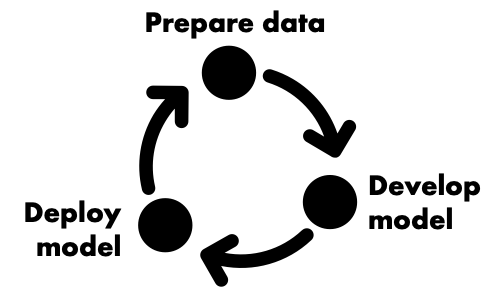
  </td>
</tr>
<tr>
  <th>The ML Lifecycle</a></th>
</tr>
</table>

> **Quick note**: The ML terms _"productionalizing"_, _"operationalizing"_, or _"deploying"_ a model all refer to the process of providing the model for other users to make predictions. The term _"model inference"_ is the stage of the machine learning lifecycle when we make predictions, which is also referred to as _"scoring"_ new data.

While it’s difficult to estimate the overall contribution of ML to the climate crisis, the field of Information and Communications Technology (ICT) accounts for about 1.4% of global GHG emissions. Roughly one-third of these emissions are related to the manufacture and handling of physical materials [1].  

### **1.3.1 Case study: ChatGPT** 🤖

While ICT's contribution to global emissions may seem small, the amount of compute needed to achieve state-of-the-art ML performance has historically doubled every 3.4 months [4]. These energy increases could be offset by hardware and algorithmic improvements [5]. But given the latest trend toward developing ever larger and more complex models, such as ChatGPT, we should remain vigilant in tracking and reducing the emissions associated with machine learning models.

With that in mind, let's take a closer look at the emissions involved with both training and using ChatGPT!

Training ChatGPT’s underlying language model, GPT-3, consumed an estimated 1,287 MWh [5]. To put this number in perspective, the average annual electricity consumption for an American in 2021 was 10,632 kWh [10]. That means the energy used to train GPT-3 was the equivalent of adding 121 additional Americans to the grid for one year.

Of course, we only realize value from GPT-3 when it's used by the world. ChatGPT saw more than 590 million unique visits in January 2023 alone [9]. When we calculate a model’s carbon impact, we must consider all aspects of the ML lifecycle.

Based on some [back-of-the-envelope calculations](https://towardsdatascience.com/chatgpts-electricity-consumption-7873483feac4) by Kasper Groes Albin Ludvigsen, ChatGPT’s electricity consumption in January 2023 is estimated to have been between 1,168 MWh and 23,364 MWh&mdash;roughly 1 and 18 times the amount of energy required to initially train the model. And that’s the energy estimate for just one month!

As you integrate machine learning into your own research, you will likely train models that are far smaller than GPT-3. But that doesn’t mean that your work won’t have a climate impact. Training a useful model requires a lot of experimentation, and the energy consumed by all those iterations can add up.

To reduce emissions from machine learning, we must first track them! Even if you're unable to apply any of the suggested strategies from this tutorial to minimize your impact, simply logging and reporting the associated emissions from your ML project is an important step.

Let's learn how we can calculate these emissions in the next section.

<a name="methodology"></a>
# **2. Methodology: Estimating Emissions from ML**

A model’s carbon footprint from computing-related impacts can be estimated as the product of electricity consumed and the carbon intensity of that electricity. To reduce the climate impact of a model, we can either reduce the amount of electricity required or shift our compute to an energy grid with a lower carbon intensity.

## **2.1 Introducing CodeCarbon**

To measure the computing-related carbon footprint of ML training, we’ll use a Python package called [CodeCarbon](https://github.com/mlco2/codecarbon). CodeCarbon was first developed in 2020 by a team from [MILA](https://mila.quebec/en/), [BCG GAMMA](https://www.bcg.com/beyond-consulting/bcg-gamma/overview), [Haverford College](https://www.haverford.edu/), and [Comet](https://www.comet.com/site/).

CodeCarbon uses the following formula to calculate the carbon footprint of executing your code:

<center><p><p> <img src="https://github.com/mlco2/codecarbon/raw/master/docs/edit/images/calculation.png" alt="alt" width="75%"/></center>

There are several other packages that provide similar functionality, such as [carbontracker](https://github.com/lfwa/carbontracker), [experiment-impact-tracker](https://github.com/Breakend/experiment-impact-tracker), and [eco2ai](https://github.com/sb-ai-lab/Eco2AI). However, CodeCarbon remains the most continuously updated and supported codebase among these emissions trackers.

If you're interested in learning more about the differences among these open-source trackers, please see Table 1 in [6].

## **2.2 Initializing the CodeCarbon tracker**

Let's start using CodeCarbon!

Note that CodeCarbon is not limited to measuring the impact of machine learning code. You can instantiate the tracker at any time to measure emissions from executing any type of code.

If you're more familiar with Python, you can also add the CodeCarbon tracker to your code as a context manager or as a decorator. Check out the [CodeCarbon documentation](https://mlco2.github.io/codecarbon/usage.html#) for more information on these techniques.

In [ ]:
# Instantiate the tracker object
tracker = EmissionsTracker(
    output_dir="./code_carbon/",  # define the directory to which we'll write our emissions results
    output_file="emissions.csv",  # define the name of the file containing our emissions results
    # log_level='error' # comment out this line to see regular output
)
tracker.start()

[codecarbon WARNING @ 20:47:57] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 20:47:57] [setup] RAM Tracking...
[codecarbon INFO @ 20:47:57] [setup] GPU Tracking...
[codecarbon INFO @ 20:47:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:47:57] [setup] CPU Tracking...
[codecarbon WARNING @ 20:47:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:47:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:47:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 20:47:58] >>> Tracker's metadata:
[codecarbon INFO @ 20:47:58]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 20:47:58]   Python version: 3.10.12
[codecarbon INFO @ 20:47:58]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 20:47:58]   Available RAM : 12.675 GB
[codecarbon INFO @ 20:47:58]   CPU count: 2
[codecarbon INFO

## **2.3 Measuring Power Usage**

First, let's define some commonly used hardware in the field of machine learning:
- **CPU:** Central Processing Unit
  - Manages all general-purpose programming.
- **GPU:** Graphical Processing Unit
  - Enhances computer graphics and accelerates machine learning workloads.
- **TPU:** Tensor Processing Unit
  - Google's custom-built processors to accelerate TensorFlow projects. [TensorFlow](https://www.tensorflow.org/) is a popular open-source deep learning framework developed by Google.
- **RAM:** Random Access Memory
  - Temporary memory that a computer can access quickly.

The main difference between CPU's and newer processors like GPU's and TPU's is the number of cores. You can think of a "core" as the basic building block of a processor&mdash;the more cores within a processor, the more processes that hardware can execute at one time.

CPU's contain only a handful of cores, which means they can only execute a few processes simultaneously. This is known as _serial processing_.

In contrast, GPU's and TPU's have thousands of cores, which means they can break down complicated tasks into thousands (or even millions!) of separate processes and execute them at the same time. This is known as _parallel processing_.

For a more intuitive understanding of the difference between serial and parallel processing, I recommend watching the Mythbusters video below.

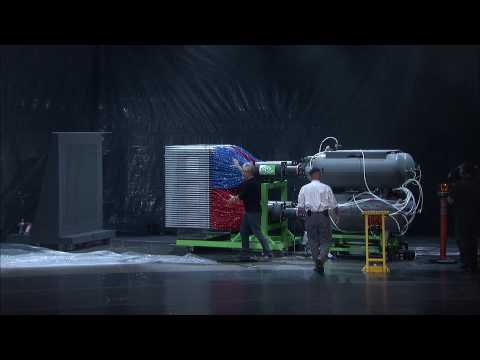

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("-P28LKWTzrI")

#### **2.3.1 Hardware Power Consumption**

Hardware power consumption is often measured in Thermal Design Power (TDP), which represents the maximum amount of heat a CPU or GPU will generate under an intense workload.

Processors that specialize in parallel processing typically consume more power than CPU's. For example, the median TDP of the [CPU list maintained by CodeCarbon](https://github.com/mlco2/codecarbon/blob/master/codecarbon/data/hardware/cpu_power.csv) is 65 W. Meanwhile, the TDP of GPU's usually exceeds 100 W.

This does not mean that leveraging a GPU to train your machine learning model necessarily results in greater emissions. Thanks to parallel processing, GPU's can dramatically shorten the time needed to train a large model and reduce the overall power load from the task.

The question of which kind of hardware is "greener" depends on the situation. Research has found that there is likely a specific optimal number of cores we could leverage in a given parallel computation to minimize emissions, as illustrated in the plot below [11].

<center><p><p> <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*bFhKxp5JhjA_RQ_hIo1pHQ.png" alt="alt" width="60%"/></center>

### **2.3.2 CodeCarbon Hardware Tracking**

CodeCarbon measures the electricity consumption of the GPU, CPU, and RAM used for executing your code (note that as of April 2023, [TPU’s are not supported](https://github.com/mlco2/codecarbon/issues/116) due to the difficulty of obtaining live power usage for this type of hardware). These measurements are taken at regular time intervals, with a default setting of 15 seconds.

Let's see what hardware CodeCarbon has found running under the hood of this Colab notebook. The last 5 lines of the output from when we instantiated the `tracker` object are the most meaningful. Here is what was displayed to me when I ran this notebook in April 2023:
```
[codecarbon INFO @ 13:07:27]   Available RAM : 12.681 GB
[codecarbon INFO @ 13:07:27]   CPU count: 2
[codecarbon INFO @ 13:07:27]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 13:07:27]   GPU count: 1
[codecarbon INFO @ 13:07:27]   GPU model: 1 x Tesla T4
```

CodeCarbon has assessed the memory of my RAM (12.681 GB) and assumes that each 8 GB of memory accounts for 3 W of power. Therefore, CodeCarbon will multiply our RAM's memory by 3/8 to determine the power consumption in watts. In our case, that comes out to about 4.76 W.

CodeCarbon has also counted two Intel(R) Xeon(R) CPU's. You might notice a WARNING in your output that reads:
```
[codecarbon WARNING @ 13:07:25] No CPU tracking mode found. Falling back on CPU constant mode.
```
This means that Colab does not expose enough information about the available CPU's for CodeCarbon to accurately assess their power consumption. To compensate, CodeCarbon will assign a constant TDP of 85 W for all CPU power expenditure and assumes that only half of that TDP is consumed on average. Therefore the final power assigned to our CPU's is 42.5 W.

Finally, we note that CodeCarbon has found one Nvidia Tesla T4 GPU. CodeCarbon leverages Nvidia's [`pynvml`](https://pypi.org/project/pynvml/) library to directly access the GPU's power rating.

In [ ]:
# Note that CodeCarbon will output the energy consumption every time you execute code
# Comment out the `log_level` argument when instantiating the tracker to suppress this output
print("All hardware identified:", tracker._hardware)
print("GPU Power:", tracker._hardware[1].total_power())

All hardware identified: [RAM(), GPU() (Tesla T4), CPU(Intel(R) Xeon(R) CPU @ 2.30GHz > 85W [generic])]
GPU Power: Power(kW=0)


## **2.4 Measuring Carbon Intensity**

CodeCarbon calculates a weighted average of the emissions from the energy sources that make up your local grid (or the grid used by your cloud provider). When available, CodeCarbon uses the global carbon intensity of electricity per [cloud provider](https://github.com/mlco2/codecarbon/blob/master/codecarbon/data/cloud/impact.csv) or per [country](https://github.com/mlco2/codecarbon/blob/master/codecarbon/data/private_infra/eu-carbon-intensity-electricity.csv).  

If the carbon intensity of a particular country is unavailable, CodeCarbon may still have access to its electricity mix and will use the [carbon intensities of each energy source](https://mlco2.github.io/codecarbon/methodology.html#id4) to calculate the weighted average. Note that the package assigns the same carbon intensity to an energy source regardless of where the energy is produced (i.e. coal's carbon intensity is considered to be the same in both West Virginia and Germany).

If neither the country’s carbon intensity or its energy mix is available, CodeCarbon applies the world average of 475 g CO<sub>2</sub>eq/kWh. Note that "CO<sub>2</sub>eq" stands for "carbon dioxide equivalents" and represents the global warming potential of various greenhouse gases.

> **IMPORTANT NOTE:** Given the simplifying assumptions on an energy grid's carbon intensity listed above, the emissions returned by CodeCarbon are only an estimate!



### 2.4.1 Colab Compute Region

Let's determine what compute region Colab has selected.

In [ ]:
tracker._geo

GeoMetadata(country_iso_code=USA, country_name=United States, region=iowa)

Colab has connected to Google's data center in Iowa to execute my code. Note that Colab might connect to a different region every time you restart your runtime. For example, I'm physically located in Chicago but Colab often connects me to Singapore's data center!

[CodeCarbon's data](https://github.com/mlco2/codecarbon/blob/master/codecarbon/data/private_infra/2016/usa_emissions.json) estimates that Iowa's energy grid has an energy intensity of about 998 lbs CO<sub>2</sub>eq per MWh as of 2016. Unfortunately, CodeCarbon does not have more recent estimates of energy intensity for regions in the USA or Canada.

A quick scan of CodeCarbon's 2016 [USA energy intensities](https://github.com/mlco2/codecarbon/blob/master/codecarbon/data/private_infra/2016/usa_emissions.json) shows that Iowa falls somewhere in the middle of U.S. states. If we wanted to optimize our energy efficiency, we might restart our runtime until we connected to Vermont (57 lbs CO<sub>2</sub>eq/MWh) or Idaho (189 lbs CO<sub>2</sub>eq/MWh).

This kind of energy efficiency optimization is much easier for cloud environments such as AWS, GCP, or Azure that allow you to choose which compute region you'd like to connect to.

## **2.5 CodeCarbon Dashboard**

Stopping the tracker will total up all the energy consumed by this hardware since the tracker's initialization and multiply by our grid's energy intensity to estimate emissions in CO<sub>2</sub>eq.

> **IMPORTANT NOTE**: Since it is unlikely that Colab will provision you with the same underlying hardware and connect you to the same compute region as when I ran this notebook, your emissions from running this code will probably differ from those currently displayed in the tutorial!

Once stopped, the tracker will create a new file (in this case titled `emissions.csv`) in our notebook's working directory with info on the emissions generated from this experiment

In [ ]:
emissions = tracker.stop()
print(f"Emissions from this training run: {emissions:5f} kg CO2eq")

[codecarbon INFO @ 20:48:04] Energy consumed for RAM : 0.000007 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 20:48:04] Energy consumed for all GPUs : 0.000015 kWh. Total GPU Power : 9.622237705576548 W
[codecarbon INFO @ 20:48:04] Energy consumed for all CPUs : 0.000065 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:48:04] 0.000086 kWh of electricity used since the beginning.


Emissions from this training run: 0.000039 kg CO2eq


We can also contextualize these emissions via CodeCarbon's dashboard.

This dashboard is hosted via a Dash app. In order to access this app on Colab's servers, we'll need a proxy link. After executing the cell below, click on the link next to the text stating "CLICK HERE". Once you're done reviewing the dashboard, click on the cell's stop button ⏹.

In [ ]:
## UNCOMMENT THIS CELL TO RUN THE CODECARBON DASHBOARD ##

# # Display the proxy link
# print("CLICK HERE:", eval_js("google.colab.kernel.proxyPort(8050)"), "\n")

# # Point to our emissions csv file
# !carbonboard --filepath="code_carbon/emissions.csv" --port=8050

When I ran this notebook in April 2023, executing just a few cells of code to assess our underlying hardware and compute region resulted in carbon emissions equivalent to watching 7 minutes of a 32-inch LCD TV.  

<a name="codecarbon-experiments"></a>
# **3. CodeCarbon Experiments**

Let's try tracking our carbon emissions while training a machine learning model. We'll also explore a few techniques to train in a more efficient way and reduce our emissions.

## **3.1 Generate Training and Test Data**

We'll use the same data as the [Forecasting the El Nino / Southern Oscillation with Machine Learning tutorial](https://colab.research.google.com/drive/1nOL7rB8EnFTvLoarerVOtECYBwJKth-t?usp=sharing) from earlier in the Summer School program. Remember that the goal of that tutorial was to leverage historical sea surface temperatures to correctly forecast the Nino3.4 index, which indicates the state of El Nino / Southern Oscillation (ENSO).

We'll move quickly through this data preparation section as the focus of this tutorial is on model training and emissions tracking. For a more detailed walkthrough, please reference the original forecasting tutorial.

In [ ]:
# Download Nino3.4 index (this index measures the state of ENSO by encoding the
# average temperature anomaly in the equatorial Pacific)
!gdown --id 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t
To: /content/nino34.long.anom.data.txt
100% 15.4k/15.4k [00:00<00:00, 38.3MB/s]


In [ ]:
# Download sst observations from 1880 to 2018
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

Downloading...
From (original): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
From (redirected): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc&confirm=t&uuid=45077f64-8cbf-4863-8235-13ed4a2163ac
To: /content/sst.mon.mean.trefadj.anom.1880to2018.nc
100% 432M/432M [00:03<00:00, 117MB/s]


In [ ]:
def load_enso_indices():
    """
    Reads in the txt data file to output a pandas Series of ENSO vals

    Returns:
      pd.Series: monthly ENSO values starting from 1870-01-01
    """
    with open("nino34.long.anom.data.txt") as f:
        line = f.readline()
        enso_vals = []
        while line:
            yearly_enso_vals = map(float, line.split()[1:])
            enso_vals.extend(yearly_enso_vals)
            line = f.readline()

    enso_vals = pd.Series(enso_vals)
    enso_vals.index = pd.date_range("1870-01-01", freq="MS", periods=len(enso_vals))
    enso_vals.index = pd.to_datetime(enso_vals.index)
    return enso_vals


def assemble_basic_predictors_predictands(start_date, end_date, lead_time):
    """
    Creates a tuple of the predictors (np array of sst temperature anomalies)
    and the predictands (np array the ENSO index at the specified lead time).

    Parameters:
        start_date (str): the start date from which to extract sst
        end_date (str): the end date
        lead_time (str): the number of months between each sst
            value and the target Nino3.4 Index

    Returns:
        (np.array, np.array)

    """
    ds = xr.open_dataset("sst.mon.mean.trefadj.anom.1880to2018.nc")
    sst = ds["sst"].sel(time=slice(start_date, end_date))
    num_time_steps = sst.shape[0]

    # sst is a 3D array: (time_steps, lat, lon)
    # in this tutorial, we will not be using ML models that take
    # advantage of the spatial nature of global temperature
    # therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    # (At each time step, there are lat*lon predictors)
    sst = sst.values.reshape(num_time_steps, -1)
    sst[np.isnan(sst)] = 0

    X = sst

    start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time)
    end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    y = load_enso_indices()[slice(start_date_plus_lead, end_date_plus_lead)]

    ds.close()
    return X, y


def plot_nino_time_series(y, predictions, title):
    """
    Plots the ENSO time series against the predictions.

    Parameters:
      y (pd.Series): time series of the true Nino index
      predictions (np.array): time series of the predicted Nino index (same
          length and time as y)
      title (str): the title of the plot

    Returns:
      (None): Displays the plot
    """
    predictions = pd.Series(predictions, index=y.index)
    predictions = predictions.sort_index()
    y = y.sort_index()

    plt.plot(y, label="Ground Truth")
    plt.plot(predictions, "--", label="ML Predictions")
    plt.legend(loc="best")
    plt.title(title)
    plt.ylabel("Nino3.4 Index")
    plt.xlabel("Date")
    plt.show()
    plt.close()

## **3.2 Algorithm Choice**

One of the easiest ways to reduce emissions is by choosing a simpler algorithm. We often don't need to immediately reach for a complicated neural network when a more traditional machine learning method would suffice.


<table style="text-align: center;" width="50%">
<tr>
  <td>
   <img src="https://external-preview.redd.it/khzQQ3xzswIW4HGIvesRWJXvCbnvdWNarIyU4-GVl2I.jpg?width=640&crop=smart&auto=webp&s=180b2912c6bef455fcb4ef7565dd5093edbabe23" width="100%">
  </td>
</tr>
<tr>
  <th>Applying a neural network when linear regression would do.</a></th>
</tr>
</table>

We'll discuss more about the potential trade-offs involved in choosing a simple algorithm over a more complicated one at the end of this section. For now, we'll focus on training two different models and capturing the emissions from each one.




### **3.2.1 Training a Baseline Model: Linear Regression**

Let's first attempt to model ENSO using linear regression. We'll track the emissions associated with training this simple model.

In [ ]:
experiment_name = "linear_regression"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

RMSE: 0.53


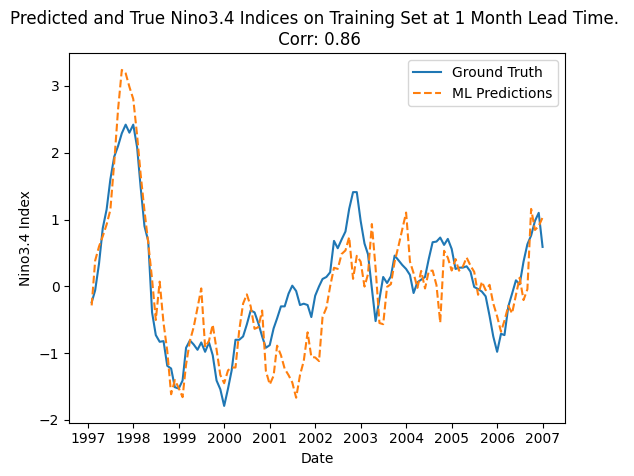

In [ ]:
# Load train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands(
    "1980-01-01", "1995-12-31", lead_time=1
)
X_val, y_val = assemble_basic_predictors_predictands(
    "1997-01-01", "2006-12-31", lead_time=1
)
X_test, y_test = assemble_basic_predictors_predictands(
    "2007-01-01", "2017-12-31", lead_time=1
)

# Train a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train, y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
baseline_rmse = mean_squared_error(y_val, predictions, squared=False)
print("RMSE: {:.2f}".format(baseline_rmse))

# Plot predictions against actuals
plot_nino_time_series(
    y_val,
    predictions,
    "Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}".format(
        corr
    ),
)

In [ ]:
# Evaluate emissions
baseline_emissions = tracker.stop()
print(f"Emissions from this training run: {baseline_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.00003 kg CO2eq


### **3.2.2 Training a CNN**

Let's compare the emissions and performance of a linear regression model to a more complex convolutional neural network (CNN).

First, we'll define some necessary data wrangling code.

In [ ]:
def assemble_predictors_predictands(start_date, end_date, lead_time,
                                    num_input_time_steps=1):
    """
    Creates a tuple of the predictors (np array of sst temperature anomalies)
    and the predictands (np array the ENSO index at the specified lead time).

    Parameters:
      start_date (str): the start date from which to extract sst
      end_date (str): the end date
      lead_time (int): the number of months between each sst value and the
          target Nino3.4 Index
      num_input_time_steps (int): the number of time steps to use for each
          predictor sample

    Returns:
      (np.array, np.array)

    """
    file_name = "sst.mon.mean.trefadj.anom.1880to2018.nc"
    variable_name = "sst"
    ds = xr.open_dataset(file_name)
    sst = ds[variable_name].sel(time=slice(start_date, end_date))

    num_samples = sst.shape[0]
    # sst is a (num_samples, lat, lon) array
    # the line below converts it to (num_samples, num_input_time_steps, lat, lon)
    sst = np.stack(
        [
            sst.values[n - num_input_time_steps : n]
            for n in range(num_input_time_steps, num_samples + 1)
        ]
    )
    num_samples = sst.shape[0]
    sst[np.isnan(sst)] = 0
    X = sst

    start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(
        months=lead_time + num_input_time_steps - 1
    )
    end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    y = load_enso_indices()[slice(start_date_plus_lead, end_date_plus_lead)]
    ds.close()
    return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert (
            self.predictors.shape[0] == self.predictands.shape[0]
        ), "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

Now we'll define the architecture of our convolutional neural network.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        Constructs all the necessary attributes for the CNN class.

        Parameters:
          num_input_time_steps (int) : the number of input time steps in the predictor
          print_feature_dimension (bool) : whether or not to print out the dimension
              of the features extracted from the conv layers
        """
        super().__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        # TIP: print out the dimension of the extracted features from
        # the conv layers for setting the dimension of the linear layer!
        # Using the print_layer, we find that the dimensions are
        # (batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
            x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Print(nn.Module):
    """
    This class prints out the size of the features
    """

    def forward(self, x):
        print(x.size())
        return x

Let's define a class to train our CNN.

In [ ]:
class TrainCNN:
    def __init__(self, trainloader, testloader, net, criterion, optimizer):
        """
        Contains the necessary code for training a CNN.

        Parameters
          trainloader (torch.utils.data.DataLoader): PyTorch dataloader that loads the
              predictors and predictands for the train dataset
          testloader (torch.utils.data.DataLoader): PyTorch dataloader that loads the
              predictors and predictands for the test dataset
          net (nn.Module): Neural network architecture
          criterion (nn): Loss function (i.e. root mean squared error)
          optimizer (torch.optim): Optimizer to use update the neural network
              architecture to minimize the loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.train_losses = []
        self.test_losses = []
        self.best_loss = np.infty

    def _calculate_loss(self, data):
        """
        Calculates the loss of the current model.

        Parameters:
          data (torch.Tensor): Predictors and predictands against which to
              calculate loss of the current model

        Returns:
            torch.Tensor
        """
        # Get a mini-batch of predictors and predictands
        batch_predictors, batch_predictands = data
        batch_predictands = batch_predictands.to(self.device)
        batch_predictors = batch_predictors.to(self.device)

        # Zero the parameter gradients
        self.optimizer.zero_grad()

        # Calculate the predictions of the current neural network
        predictions = self.net(batch_predictors).squeeze(1)

        # Quantify the quality of the predictions using a
        # loss function (aka criterion) that is differentiable
        loss = self.criterion(predictions, batch_predictands)
        return loss

    def _train(self):
        """
        Trains the CNN for one iteration.

        Returns:
            None: Appends the current training loss
        """
        running_loss = 0.0
        self.net.train()

        for i, data in enumerate(self.trainloader):
            loss = self._calculate_loss(data)

            # The backward pass: calculates the gradients of each weight
            # of the neural network with respect to the loss
            loss.backward()

            # The optimizer updates the weights of the neural network
            # based on the gradients calculated above and the choice
            # of optimization algorithm
            self.optimizer.step()
            running_loss += loss.item()

        self.train_losses.append(running_loss / len(self.trainloader))

    def _evaluate_epoch(self):
        """
        Evaluates the test loss at the current epoch and updates the best loss
        if current loss is less than the previous best loss.

        Return:
          None: Appends the current test loss
        """
        running_loss = 0.0
        self.net.eval()

        for i, data in enumerate(self.testloader):
            loss = self._calculate_loss(data)
            running_loss += loss.item()

        # Save the model weights that have the best performance!
        if running_loss < self.best_loss:
            self.best_loss = running_loss
            torch.save(self.net, "current_best_cnn.pt")

        self.test_losses.append(running_loss / len(self.testloader))

    def train_network(self, num_epochs=40, verbose=True):
        """
        Trains a neural network for a specified number of epochs.

        Parameters:
          num_epochs (int): Number of epochs for which to train the network
          verbose (bool): Whether or not to print the current train and test loss

        Returns:
          None
        """
        net = self.net.to(self.device)
        for epoch in range(num_epochs):
            self._train()
            self._evaluate_epoch()
            if verbose:
                print(
                    "train Set: Epoch {:02d}. loss: {:3f}".format(
                        epoch + 1, self.train_losses[-1]
                    )
                )
                print(
                    "test Set: Epoch {:02d}. loss: {:3f}".format(
                        epoch + 1, self.test_losses[-1]
                    )
                )

        self.net = torch.load("current_best_cnn.pt")
        self.net.eval()
        self.net.to(self.device)

    def evaluate_best_model(self):
        """
        Makes predictions against the current best model.

        Returns:
          np.array: Predictions from the model
        """
        if self.best_loss == np.infty:
            raise Exception("The model has not yet been trained!")

        predictions = np.asarray([])
        for i, data in enumerate(self.testloader):
            batch_predictors, batch_predictands = data
            batch_predictands = batch_predictands.to(self.device)
            batch_predictors = batch_predictors.to(self.device)

            batch_predictions = self.net(batch_predictors).squeeze()
            # Edge case: if there is 1 item in the batch, batch_predictions becomes a float
            # not a Tensor. the if statement below converts it to a Tensor
            # so that it is compatible with np.concatenate
            if len(batch_predictions.size()) == 0:
                batch_predictions = torch.Tensor([batch_predictions])
            predictions = np.concatenate(
                [predictions, batch_predictions.detach().cpu().numpy()]
            )
        return predictions

Now we'll kick off a new CodeCarbon experiment to track emissions from training this simple CNN.

In [ ]:
experiment_name = "cnn"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

In [ ]:
# Assemble numpy arrays corresponding to predictors and predictands
train_start_date = "1960-01-01"
train_end_date = "2005-12-31"
num_input_time_steps = 1
lead_time = 1

train_predictors, train_predictands = assemble_predictors_predictands(
    train_start_date,
    train_end_date,
    lead_time,
    num_input_time_steps=num_input_time_steps,
)
test_predictors, test_predictands = assemble_predictors_predictands(
    "2007-01-01",
    "2017-12-31",
    lead_time,
    num_input_time_steps=num_input_time_steps,
)

# Convert the numpy ararys into ENSODataset, which is a subset of the
# torch.utils.data.Dataset class.  This class is compatible with
# the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

# Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)

In [ ]:
# Train the model
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
cnn_train_session = TrainCNN(
    trainloader, testloader, net, criterion=nn.MSELoss(), optimizer=optimizer
)
cnn_train_session.train_network()

# Evaluate predictions from the best performing model
predictions = cnn_train_session.evaluate_best_model()

train Set: Epoch 01. loss: 0.495985
test Set: Epoch 01. loss: 0.224990
train Set: Epoch 02. loss: 0.144434
test Set: Epoch 02. loss: 0.147177
train Set: Epoch 03. loss: 0.075182
test Set: Epoch 03. loss: 0.088368
train Set: Epoch 04. loss: 0.068121
test Set: Epoch 04. loss: 0.145498
train Set: Epoch 05. loss: 0.097352
test Set: Epoch 05. loss: 0.146497
train Set: Epoch 06. loss: 0.074418
test Set: Epoch 06. loss: 0.166956
train Set: Epoch 07. loss: 0.093299
test Set: Epoch 07. loss: 0.126439
train Set: Epoch 08. loss: 0.059650
test Set: Epoch 08. loss: 0.108328
train Set: Epoch 09. loss: 0.049280
test Set: Epoch 09. loss: 0.104557
train Set: Epoch 10. loss: 0.049032
test Set: Epoch 10. loss: 0.107669
train Set: Epoch 11. loss: 0.060282
test Set: Epoch 11. loss: 0.157027
train Set: Epoch 12. loss: 0.062719
test Set: Epoch 12. loss: 0.210341
train Set: Epoch 13. loss: 0.050344
test Set: Epoch 13. loss: 0.115268
train Set: Epoch 14. loss: 0.054485
test Set: Epoch 14. loss: 0.087400
train 

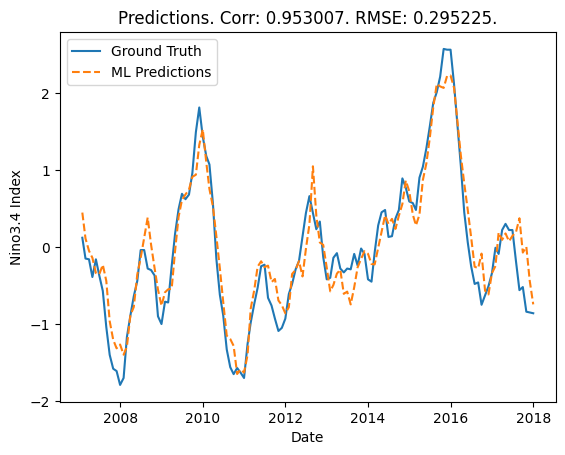

In [ ]:
# Plot predictions against actuals over time
corr, _ = pearsonr(test_predictands, predictions)
cnn_rmse = mean_squared_error(test_predictands, predictions, squared=False)
plot_nino_time_series(
    test_predictands,
    predictions,
    "Predictions. Corr: {:3f}. RMSE: {:3f}.".format(corr, cnn_rmse),
)

In [ ]:
# Stopping the tracker will create a new file (emissions.csv) in our notebook's
# working directory with info on the emissions generated from this experiment
cnn_emissions = tracker.stop()
print(f"Emissions from this training run: {cnn_emissions:5f} kg CO2eq")

Emissions from this training run: 0.000362 kg CO2eq


### **3.2.3 Comparing Emissions and Accuracy**

Let's compare the emissions from training a linear regression model with those from training a CNN.

In [ ]:
print(
    f"CNN emissions account for {cnn_emissions/baseline_emissions:.1f} times the emissions from linear regression."
)

CNN emissions account for 11.9 times the emissions from linear regression.


Wow! Linear regression is the clear environmental winner in terms of reducing carbon impact. Of course, we must also consider the performance of our model. How well does it forecast ENSO? Let's compare the root squared mean error (RMSE) from both models. Remember that a lower RMSE indicates a better fit.

In [ ]:
print(f"Previous baseline RMSE: {baseline_rmse:5f}")
print(f"Current CNN RMSE: {cnn_rmse:5f}")

Previous baseline RMSE: 0.525526
Current CNN RMSE: 0.295225


As expected, those extra emissions from training the CNN resulted in a performance boost. Research indicates that ML model quality has a diminishing power-law relationship with energy consumption ($ Q\:α \: E^{-k} $, where $Q$ is model quality and $E$ is energy consumed). However, the power of this relationship ($k$) is very small (0.002-0.004) [7]. This means we need to expend a lot more energy for marginal performance gains.

Whether or not this extra accuracy is necessary depends on your situation. For example, we'd prioritize accuracy at all costs for a model that detects lung cancer from CT scans. We wouldn't want to miss any early indications on a sick patient and conversely, we wouldn't want to cause undue stress by incorrectly diagnosing a healthy patient with cancer. On the other hand, we might not need the most accurate model when predicting which customers are likely to churn from an online retailer since the cost of being wrong is much lower than our lung cancer example.

Let's visualize the relationship between emissions and performance for these two models.

In [ ]:
def plot_comparison(results):
    """
    Plots GHG emissions against RMSE.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(results["Category"], results["Emissions"], label="Emissions (g CO2eq)")
    ax.set_ylabel("Emissions (g CO2eq)")

    ax2 = ax.twinx()
    ax2.scatter(
        results["Category"], results["RMSE"], color="orange", label="RMSE",
    )
    ax2.set_ylabel("RMSE")
    ax2.set_ylim([0, max(results["RMSE"]) * 1.2])

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(
        lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.9)
    );

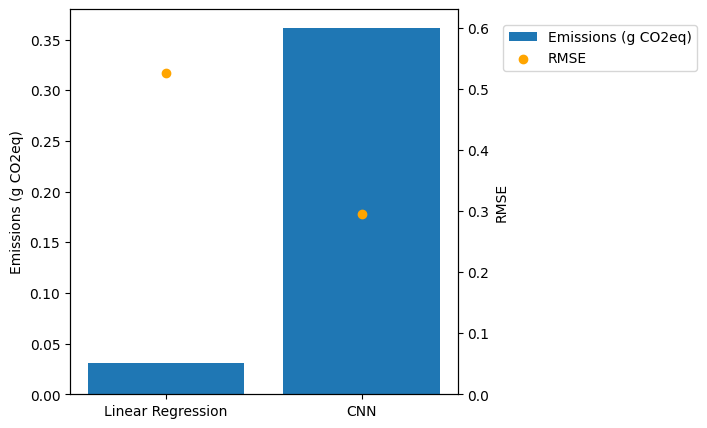

In [ ]:
model_results = pd.DataFrame(
    {
        "Category": ["Linear Regression", "CNN"],
        "RMSE": [baseline_rmse, cnn_rmse],
        "Emissions": [baseline_emissions * 1000, cnn_emissions * 1000],
    }
)

plot_comparison(model_results)

### Exercise 1

⭐ **YOUR TURN!:** Try reducing the size of the CNN by removing the second linear layer within the CNNReduced class in the cell below. How does this change affect the model's performance and efficiency in terms of emissions?

In [ ]:
class CNNReduced(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        Constructs all the necessary attributes for a CNN class.

        Parameters:
          num_input_time_steps (int) : the number of input time steps in the predictor
          print_feature_dimension (bool) : whether or not to print out the dimension
              of the features extracted from the conv layers
        """
        # this class inherits its attributes from the CNN class above!
        super().__init__(num_input_time_steps, print_feature_dimension)

        # TIP: print out the dimension of the extracted features from
        # the conv layers for setting the dimension of the linear layer!
        # Using the print_layer, we find that the dimensions are
        # (batch_size, 16, 42, 87)

        # Part 1
        self.fc1 = ### YOUR CODE HERE ###
        self.fc2 = ### YOUR CODE HERE ###

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
            x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        # Part 2
        x = ### YOUR CODE HERE ###
        x = ### YOUR CODE HERE ###
        return x

In [ ]:
experiment_name = "cnn_reduced"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

In [ ]:
# Train the reduced model with the same number of input time steps (num_input_time_steps)
# as the previous CNN

# Part 3
net = ### YOUR CODE HERE ###
optimizer = optim.Adam(net.parameters(), lr=0.0001)
cnn_train_session_reduced = TrainCNN(
    trainloader, testloader, net, criterion=nn.MSELoss(), optimizer=optimizer
)
cnn_train_session_reduced.train_network()

# Evaluate predictions from the best performing model
predictions_cnn_reduced = cnn_train_session_reduced.evaluate_best_model()

Let's evaluate the results from the reduced CNN.

In [ ]:
cnn_reduced_rmse = mean_squared_error(test_predictands, predictions_cnn_reduced, squared=False)

print(f"Previous CNN RMSE: {cnn_rmse:5f}")
print(f"Reduced CNN RMSE: {cnn_reduced_rmse:5f}")

In [ ]:
cnn_reduced_emissions = tracker.stop()
print(f"Emissions from this training run: {cnn_reduced_emissions:5f} kg CO2eq")

In [ ]:
model_results = pd.DataFrame(
    {
        "Category": ["Original CNN", "Reduced CNN"],
        "RMSE": [cnn_rmse, cnn_reduced_rmse],
        "Emissions": [cnn_emissions * 1000, cnn_reduced_emissions * 1000],
    }
)

plot_comparison(model_results)

In [ ]:
print(
    f"What is the percentage that emissions were reduced by removing the second layer of the CNN?\n{(cnn_emissions - cnn_reduced_emissions)/cnn_emissions:.1%}"
)
print('')
print(
    f"How much did error increase by removing the second layer?\n{abs(cnn_rmse - cnn_reduced_rmse)/cnn_rmse:.1%}"
)

#### Solution

In [ ]:
# Part 1
self.fc1 = nn.Linear(16 * 42 * 87, 120)
self.fc2 = nn.Linear(120, 1)

In [ ]:
# Part 2
x = F.relu(self.fc1(x))
x = self.fc2(x)

In [ ]:
# Part 3
net = CNNReduced(num_input_time_steps=num_input_time_steps)

You should find that emissions are reduced by 16-18% and error increases by around 10-12%.

### Exercise 2

⭐ **YOUR TURN!:** If you're more familiar with neural networks, experiment with applying early stopping to our CNN training process. An "early stopping" approach will terminate training if the model's validation loss doesn't decrease for several epochs in a row. How does reducing the number of epochs via early stopping affect the final model's performance and its emissions?

In [ ]:
class TrainCNNwithEarlyStopping(TrainCNN):
    def __init__(self, trainloader, testloader, net, criterion, optimizer,
                 patience):
        """
        Contains the necessary code for training a CNN with early stopping.

        Parameters
          trainloader (torch.utils.data.DataLoader): PyTorch dataloader that loads the
              predictors and predictands for the train dataset
          testloader (torch.utils.data.DataLoader): PyTorch dataloader that loads the
              predictors and predictands for the test dataset
          net (nn.Module): Neural network architecture
          criterion (nn): Loss function (i.e. root mean squared error)
          optimizer (torch.optim): Optimizer to use update the neural network
              architecture to minimize the loss function
          patience (int): Number of epochs without test loss improvement that we
              will tolerate
        """
        # this class inherits its attributes from the TrainCNN class above!
        super().__init__(trainloader, testloader, net, criterion, optimizer)
        # Part 1
        self.patience = ### YOUR CODE HERE ###
        self.current_patience = ### YOUR CODE HERE ###

    def _evaluate_epoch(self):
        """
        Evaluates the test loss at the current epoch and updates the best loss
        if current loss is less than the previous best loss.

        Return:
          None: Appends the current test loss
        """
        running_loss = 0.0
        self.net.eval()

        for i, data in enumerate(self.testloader):
            loss = self._calculate_loss(data)
            running_loss += loss.item()

        # Save the model weights that have the best performance!
        if running_loss < self.best_loss:
            self.best_loss = running_loss
            torch.save(self.net, "current_best_cnn.pt")
            # Part 2
            self.current_patience = ### YOUR CODE HERE ###
        else:
            # Part 3
            self.current_patience -= ### YOUR CODE HERE ###
            print(f'Test loss increased past best loss. Patience: {self.current_patience}')

        self.test_losses.append(running_loss / len(self.testloader))

    def train_network(self, num_epochs=40, verbose=True):
        """
        Trains a neural network for a specified number of epochs.

        Parameters:
          num_epochs (int): Number of epochs for which to train the network
          verbose (bool): Whether or not to print the current train and test loss

        Returns:
          None
        """
        net = self.net.to(self.device)
        for epoch in range(num_epochs):
            self._train()
            self._evaluate_epoch()
            if verbose:
                print(
                    "train Set: Epoch {:02d}. loss: {:3f}".format(
                        epoch + 1, self.train_losses[-1]
                    )
                )
                print(
                    "test Set: Epoch {:02d}. loss: {:3f}".format(
                        epoch + 1, self.test_losses[-1]
                    )
                )

            # Part 4
            if self.current_patience == 0:
                ### YOUR CODE HERE ###

        self.net = torch.load("current_best_cnn.pt")
        self.net.eval()
        self.net.to(self.device)

In [ ]:
experiment_name = "cnn_with_early_stopping"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

In [ ]:
# Train the model
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
cnn_train_session_early_stopping = TrainCNNwithEarlyStopping(
    trainloader, testloader, net, criterion=nn.MSELoss(), optimizer=optimizer,
    patience=15
)
cnn_train_session_early_stopping.train_network()

# Evaluate predictions from the best performing model
predictions_es = cnn_train_session_early_stopping.evaluate_best_model()

In [ ]:
cnn_emissions_es = tracker.stop()
print(f"Emissions from this training run: {cnn_emissions_es:5f} kg CO2eq")

In [ ]:
print(
    f"Early stopping reduced emissions by {(cnn_emissions - cnn_emissions_es)/cnn_emissions:.1%}."
)

cnn_with_early_stopping_rmse = mean_squared_error(test_predictands, predictions_es, squared=False)
print('')
print(
    f"RMSE before early stopping: {cnn_rmse:.3}"
)
print(
    f"RMSE with early stopping: {cnn_with_early_stopping_rmse:.3}"
)

#### Solution

In [ ]:
# Part 1
self.patience = patience
self.current_patience = self.patience

In [ ]:
# Part 2
self.current_patience = self.patience

In [ ]:
# Part 3
self.current_patience -= 1

In [ ]:
# Part 4
if self.current_patience == 0:
    break

Early stopping with a patience of 15 should reduce emissions by 30-50%. RMSE will increase by about 0.03.

### **3.2.4 Tracking Emissions from Model Inference**

As noted in our [ChatGPT example](https://colab.research.google.com/drive/1tTok_j2MZtWLuvcr6p_labPOxnCPM9ZL#scrollTo=1_3_1_Case_study_ChatGPT_) above, we must also account for the emissions associated with productionalizing a model. This consideration is situation-specific. Will millions of users predict using our model multiple times a day? Or will we only need to score new data with our model once a month?

We can use CodeCarbon again to assess the emissions associated with model inference. Note that we would need to deploy CodeCarbon on the infrastructure that hosts the productionalized model for an accurate assessment of the emissions associated with scoring. We'll measure the emissions associated with inference within the Colab notebook for illustration purposes only.

In [ ]:
# First we'll measure emissions from scoring with the linear regression model
experiment_name = "linear_regression_inference"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

predictions_test_lin_reg = regr.predict(X_test)

lin_reg_inference_emissions = tracker.stop()
print(f"Emissions from this training run: {lin_reg_inference_emissions} kg CO2eq")

Emissions from this training run: 7.097109018302615e-08 kg CO2eq


In [ ]:
# Now we measure emissions from scoring with the CNN
experiment_name = "cnn_inference"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
predictions_test_cnn = cnn_train_session.net(
    torch.Tensor(test_predictors).to(device)
).squeeze()

cnn_inference_emissions = tracker.stop()
print(f"Emissions from this training run: {cnn_inference_emissions} kg CO2eq")

Emissions from this training run: 1.1777629971019085e-07 kg CO2eq


In [ ]:
print(
    f"The emissions from scoring with a CNN are {cnn_inference_emissions/lin_reg_inference_emissions:.1f} times the emissions from scoring with a linear regression model."
)

The emissions from scoring with a CNN are 1.7 times the emissions from scoring with a linear regression model.


The difference in emissions from inference between the two models is much less dramatic than that from training. One reason for this is that deep learning models train over multiple epochs. Neural networks then typically require three times the energy to train on an observation as compared to inferring on that observation [8].

Be sure to measure emissions from scoring data samples of the scale you'd expect once you've deployed your model for the most accurate estimates!

## **3.3 Hyperparameter Tuning**

Hyperparameter tuning refers to the task of adjusting the data that governs the training process itself, such as the number of layers in a neural network. ML practitioners typically tune these hyperparameters to find a combination with an optimal model performance.

Let's explore the emissions associated with tuning the hyperparameters of our CNN and experiment with some strategies to make this process more efficient.

Note that in the interest of time, we will only explore a small hyperparameter space. However, these strategies are much more effective at reducing emissions when we need to search a large number of possible hyperparameter combinations to optimize model performance.

### **3.2.1 Introducing Optuna**

We'll use the [`optuna`](https://optuna.org/) package to tune our hyperparameters. To do so, we need to define an `objective` function such as the one below.

The `objective` function takes an input parameter called `trial`, which comes from Optuna's `Trial` class. This object logs a set of selected hyperparameter values and records the value of our objective function (RMSE in our case) from each trial.

We also define the search space of each hyperparameter as a dictionary named `params`. For each hyperparameter, we specify the range of the search space with the `suggest_*` methods.

- [**suggest_int:**](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) Suggests a value for a hyperparameter of type integer.
- [**suggest_categorical:**](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_categorical) Suggests a value for a categorical hyperparameter.
-[**suggest_float:**](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float) Suggests a value for a hyperparameter of type float. Note that you can specify a log distribution by setting the parameter `log=True`.

For our hyperparameter tuning session, we'll experiment with adjusting the learning rate and the optimizer of our CNN as well as the number of input time steps used to construct our training data.

> _Quick note:_ Remember that the parameter `num_input_time_steps` refers to the number of time steps for each predictor. For example, if num_input_time_steps is set to 3, then the machine learning model will take 3 months as its input. In other words, a sample predictor will be 3 months of average temperature: Jan average temperature, Feb average temperature, and March average temperature (i.e. an array of (3, lat, lon)). The predictand will be the Niño3.4 index lead_time months after March.
>
> Previously, we had trained our CNN using a `num_input_time_steps` value of 1.

In [ ]:
def objective(trial):
    """
    Defines the objective function.

    Parameters:
      trial (optuna.Trial): Provides interfaces to Optuna's functionality

    Returns:
      (int): RMSE of current trial
    """
    # Define the hyperparameter search space
    params = {
        "num_input_time_steps": trial.suggest_int("num_input_time_steps", 1, 3),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "optimizer": trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
    }

    # Instantiate the model
    net = CNN(num_input_time_steps=params["num_input_time_steps"])

    # Create new train and test sets based on the selected num_input_time_steps parameter
    train_predictors, train_predictands = assemble_predictors_predictands(
        start_date=train_start_date,
        end_date=train_end_date,
        lead_time=1,
        num_input_time_steps=params["num_input_time_steps"],
    )
    test_predictors, test_predictands = assemble_predictors_predictands(
        start_date="2007-01-01",
        end_date="2017-12-31",
        lead_time=1,
        num_input_time_steps=params["num_input_time_steps"],
    )

    train_dataset = ENSODataset(train_predictors, train_predictands)
    test_dataset = ENSODataset(test_predictors, test_predictands)

    trainloader = DataLoader(train_dataset, batch_size=10)
    testloader = DataLoader(test_dataset, batch_size=10)

    # Specify criterion and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = getattr(optim, params["optimizer"])(
        net.parameters(), lr=params["learning_rate"]
    )

    # Train a CNN using the specified hyperparameters and calculate RMSE
    cnn_train_session = TrainCNN(trainloader, testloader, net, criterion, optimizer)
    cnn_train_session.train_network(verbose=False)
    predictions = cnn_train_session.evaluate_best_model()
    rmse = mean_squared_error(test_predictands, predictions, squared=False)
    return rmse

### **3.3.2 TPE Search**

You might already be familiar with tuning hyperparameters via grid search in which we try every combination of hyperparameters within the space. Grid search is inherently inefficient and should be avoided in favor of more intelligent search algorithms.

One such algorithm is the Tree-structured Parzen Estimator (TPE) algorithm, which is the default hyperparameter sampling method in Optuna. On each trial for each hyperparameter, TPE fits a Gaussian Mixture Model (GMM) $l(x)$ to the hyperparameter sets that return the smallest values for the objective function.

> _Quick note:_ A Gaussian mixture model is a probabilistic model that represents normally distributed subpopulations (in this case, our hyperparameters) within an overall population. Please see this [short introduction](https://brilliant.org/wiki/gaussian-mixture-model/) for a deeper explanation.

TPE fits another GMM $g(x)$ to the remaining hyperparameter values. The hyperparameter value $x$ that maximizes the ratio $l(x)/g(x)$ would then be evaluated using the objective function. I recommend this [blog post](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f#) for more information about Bayesian-based hyperparameter tuning strategies.

TPE will run for as many trials as we specify. Let's limit ourselves to 12 trials to ensure we're not waiting too long for a result.

In [ ]:
experiment_name = "tpe_search"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

The TPE algorithm cannot operate on a "cold start"&mdash;in other words, TPE needs the results of some "startup" trials to fit the GMM $l(x)$. We set the parameter `n_startup_trials` to specify the number of trials that will initially leverage random sampling instead of TPE. The default value for this parameter is 10 but since we're only searching over 12 trials in total, we'll reduce this number to a lower value. Let's try 5.

In [ ]:
tpe_search_study = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.TPESampler(n_startup_trials=5, seed=0)
)
tpe_search_study.optimize(objective, n_trials=12, show_progress_bar=True)

[I 2024-05-21 20:48:55,844] A new study created in memory with name: no-name-0fbc0123-4b04-4ac3-bc24-31beb9bf0684


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2024-05-21 20:49:23,292] Trial 0 finished with value: 0.5133203280453079 and parameters: {'num_input_time_steps': 2, 'learning_rate': 0.0026938830192854116, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5133203280453079.
[I 2024-05-21 20:49:48,304] Trial 1 finished with value: 0.28808524127157037 and parameters: {'num_input_time_steps': 2, 'learning_rate': 0.0019578897201213002, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.28808524127157037.
[I 2024-05-21 20:50:18,608] Trial 2 finished with value: 0.27793658967002377 and parameters: {'num_input_time_steps': 3, 'learning_rate': 0.0005846326121643416, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.27793658967002377.
[I 2024-05-21 20:50:41,743] Trial 3 finished with value: 0.267026822967601 and parameters: {'num_input_time_steps': 2, 'learning_rate': 0.007098936257405904, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.267026822967601.
[I 2024-05-21 20:51:01,340] Trial 4 finished with value: 0.2608825604878818 and p

In [ ]:
print("Optimal set of hyperparameters:", tpe_search_study.best_params)
print(f"RMSE from optimal set of hyperparameters: {tpe_search_study.best_value:.5f}")
print("")
print(
    f"Hyperparameter tuning from TPE search reduced model error by {abs(1 - tpe_search_study.best_value/cnn_rmse):.1%}"
)

Optimal set of hyperparameters: {'num_input_time_steps': 1, 'learning_rate': 0.0006464039509169645, 'optimizer': 'SGD'}
RMSE from optimal set of hyperparameters: 0.24979

Hyperparameter tuning from TPE search reduced model error by 15.4%


We can see that hyperparameter tuning reduced our model's error by a decent amount. Let's tally up the emissions cost from this exercise.

In [ ]:
tpe_search_emissions = tracker.stop()
print(f"Emissions from this training run: {tpe_search_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.00410 kg CO2eq


Finally, we'll take a quick look at the fit from a CNN trained with this optimal set of hyperparameters.

In [ ]:
def train_model_with_best_parameters(params):
    """
    Trains a CNN a given set of hyperparameters.

    Parameters:
      params (dict): Dictionary containing hyperparameter names and values

    Returns:
      (np.array, np.array): Tuple of predictions and test predictands
    """
    net = CNN(num_input_time_steps=params["num_input_time_steps"])

    train_predictors, train_predictands = assemble_predictors_predictands(
        start_date=train_start_date,
        end_date=train_end_date,
        lead_time=2,
        num_input_time_steps=params["num_input_time_steps"],
    )
    test_predictors, test_predictands = assemble_predictors_predictands(
        start_date="2007-01-01",
        end_date="2017-12-31",
        lead_time=2,
        num_input_time_steps=params["num_input_time_steps"],
    )

    train_dataset = ENSODataset(train_predictors, train_predictands)
    test_dataset = ENSODataset(test_predictors, test_predictands)

    trainloader = DataLoader(train_dataset, batch_size=10)
    testloader = DataLoader(test_dataset, batch_size=10)

    # Specify criterion and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = getattr(optim, params["optimizer"])(
        net.parameters(), lr=params["learning_rate"]
    )

    cnn_train_session = TrainCNN(trainloader, testloader, net, criterion, optimizer)
    cnn_train_session.train_network(verbose=False)
    predictions = cnn_train_session.evaluate_best_model()
    return predictions, test_predictands

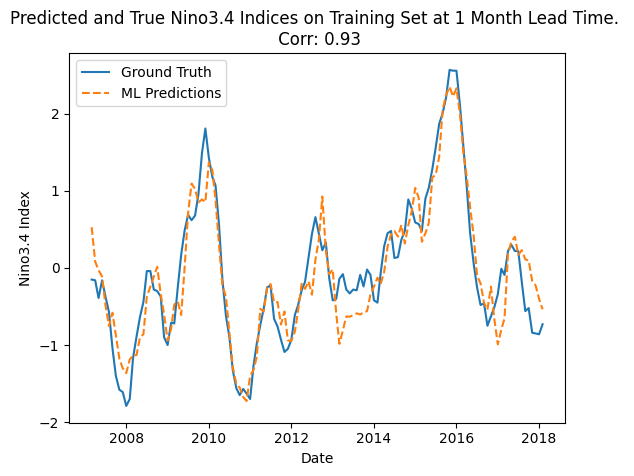

In [ ]:
predictions, test_predictands = train_model_with_best_parameters(
    tpe_search_study.best_params
)
corr, _ = scipy.stats.pearsonr(predictions, test_predictands)

plot_nino_time_series(
    test_predictands,
    predictions,
    "Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}".format(
        corr
    ),
)

### **3.3.3 With Hyperparameter Pruning**

We might wish to stop training a CNN on a certain set of hyperparameters if the intermediate objective values don't look promising. For example, we might train our CNN on certain hyperparameters and notice that the RMSE by epoch 23 is quite poor. In that case, we should terminate this trial and move on to another set of hyperparameters. This is called "hyperparameter pruning".

To implement hyperparameter pruning, we'll need to adjust our CNN training code. Below I've added lines 36-41 to the function `train_network`. This new code calculates the RMSE at each epoch and calls the Optuna trial to determine whether to prune based on our specified pruning strategy (more on pruning strategies below).




In [ ]:
class TrainCNNOptuna(TrainCNN):
    def __init__(self, trainloader, testloader, net, criterion, optimizer):
        super().__init__(trainloader, testloader, net, criterion, optimizer)

    def train_network(self, trial, num_epochs=40, verbose=True):
        """
        Trains a neural network for a specified number of epochs with an
        ability to prune via Optuna.

        Parameters:
          trial (optuna.Trial): Provides interfaces to Optuna's functionality
          num_epochs (int): Number of epochs for which to train the network
          verbose (bool): Whether or not to print the current train and test loss

        Returns:
          None
        """
        net = self.net.to(self.device)

        for epoch in range(num_epochs):
            self._train()
            self._evaluate_epoch()
            if verbose:
                print(
                    "train Set: Epoch {:02d}. loss: {:3f}".format(
                        epoch + 1, self.train_losses[-1]
                    )
                )
                print(
                    "test Set: Epoch {:02d}. loss: {:3f}".format(
                        epoch + 1, self.test_losses[-1]
                    )
                )

            # Determine if trial should be pruned
            predictions = self.evaluate_best_model()
            test_predictands = self.testloader.dataset.predictands
            rmse = mean_squared_error(test_predictands, predictions, squared=False)
            trial.report(rmse, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        self.net = torch.load("current_best_cnn.pt")
        self.net.eval()
        self.net.to(self.device)

We also need to adjust our objective function to call this new training code.

In [ ]:
def objective_with_pruning(trial):
    """
    Defines the objective function to allow for pruning.

    Parameters:
      trial (optuna.Trial): Provides interfaces to Optuna's functionality

    Returns:
      (int): RMSE of current trial
    """
    params = {
        "num_input_time_steps": trial.suggest_int("num_input_time_steps", 1, 3),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "optimizer": trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
    }

    net = CNN(num_input_time_steps=params["num_input_time_steps"])

    train_predictors, train_predictands = assemble_predictors_predictands(
        start_date=train_start_date,
        end_date=train_end_date,
        lead_time=1,
        num_input_time_steps=params["num_input_time_steps"],
    )
    test_predictors, test_predictands = assemble_predictors_predictands(
        start_date="2007-01-01",
        end_date="2017-12-31",
        lead_time=1,
        num_input_time_steps=params["num_input_time_steps"],
    )

    train_dataset = ENSODataset(train_predictors, train_predictands)
    test_dataset = ENSODataset(test_predictors, test_predictands)

    trainloader = DataLoader(train_dataset, batch_size=10)
    testloader = DataLoader(test_dataset, batch_size=10)

    # Specify criterion and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = getattr(optim, params["optimizer"])(
        net.parameters(), lr=params["learning_rate"]
    )

    cnn_train_session = TrainCNNOptuna(
        trainloader, testloader, net, criterion, optimizer
    )
    cnn_train_session.train_network(trial, verbose=False)
    predictions = cnn_train_session.evaluate_best_model()
    rmse = mean_squared_error(test_predictands, predictions, squared=False)
    return rmse

Optuna offers several different hyperparameter pruning strategies.

- `ThresholdPruner`: Prunes a trial if the intermediate value (in our case, RMSE) is worse than a specified threshold at the same training epoch.
- `MedianPruner`: Prunes a trial if the intermediate value of the current trial is worse than the median of intermediate values from previous trials at the same training epoch.
- `PercentilePruner`: Prunes a trial if the intermediate value of the current trial is in the bottom percentile of trials at the same training epoch.
- `SuccessiveHalvingPruner`: Pruning strategy based on the [Successive Halving Algorithm (SHA)](https://blog.ml.cmu.edu/2018/12/12/massively-parallel-hyperparameter-optimization/). At a high level, the algorithm allocates more epochs to promising trials by by pruning half of the total trials.

Let's experiment with the `PercentilePruner`. We'll ask Optuna to prune when the RMSE falls below the bottom 10th percentile of previous trials.

In [ ]:
experiment_name = "tpe_search_percentile_pruned"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

In [ ]:
tpe_search_10perc_pruned_study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(n_startup_trials=5, seed=0),
    pruner=optuna.pruners.PercentilePruner(percentile=10),
)
tpe_search_10perc_pruned_study.optimize(
    objective_with_pruning, n_trials=12, show_progress_bar=True
)

[I 2024-05-21 20:54:01,750] A new study created in memory with name: no-name-c875bba5-844c-4505-880c-72458e394c6d


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2024-05-21 20:54:32,094] Trial 0 finished with value: 0.42955115636006647 and parameters: {'num_input_time_steps': 2, 'learning_rate': 0.0026938830192854116, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.42955115636006647.
[I 2024-05-21 20:54:59,454] Trial 1 finished with value: 0.41900339977589907 and parameters: {'num_input_time_steps': 2, 'learning_rate': 0.0019578897201213002, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.41900339977589907.
[I 2024-05-21 20:55:33,009] Trial 2 finished with value: 0.32851481226584855 and parameters: {'num_input_time_steps': 3, 'learning_rate': 0.0005846326121643416, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.32851481226584855.
[I 2024-05-21 20:55:58,842] Trial 3 finished with value: 0.2836094376296286 and parameters: {'num_input_time_steps': 2, 'learning_rate': 0.007098936257405904, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.2836094376296286.
[I 2024-05-21 20:56:21,236] Trial 4 finished with value: 0.3239154195036823 a

In [ ]:
tpe_search_percentile_pruned_emissions = tracker.stop()
print(
    f"Emissions from this training run: {tpe_search_percentile_pruned_emissions:.5f} kg CO2eq"
)

Emissions from this training run: 0.00219 kg CO2eq


Optuna ended up pruning half our total trials! Let's see if this strategy found a comparable hyperparameter set to our previous tuning study in which we never pruned.

In [ ]:
df = pd.DataFrame(
    {
        "strategy": ["Not pruned", "Pruned"],
        "num_input_time_steps": [
            tpe_search_study.best_params["num_input_time_steps"],
            tpe_search_10perc_pruned_study.best_params["num_input_time_steps"],
        ],
        "learning_rate": [
            tpe_search_study.best_params["learning_rate"],
            tpe_search_10perc_pruned_study.best_params["learning_rate"],
        ],
        "optimizer": [
            tpe_search_study.best_params["optimizer"],
            tpe_search_10perc_pruned_study.best_params["optimizer"],
        ],
        "RMSE": [
            tpe_search_study.best_value,
            tpe_search_10perc_pruned_study.best_value,
        ],
    }
)

df.set_index("strategy")

,num_input_time_steps,learning_rate,optimizer,RMSE
strategy,,,,
Not pruned,1,0.000646,SGD,0.249791
Pruned,2,0.007099,SGD,0.283609


Our pruning strategy resulted in a slightly different set of optimal hyperparameters but with a similar RMSE!

### **3.3.4 Compare Emissions from Search Strategies**

Now let's compare emissions from both the pruned and the unpruned hyperparameter tuning studies.

In [ ]:
print(
    f"Pruning our search reduced emissions by {abs(1 - tpe_search_percentile_pruned_emissions / tpe_search_emissions):.1%}."
)

Pruning our search reduced emissions by 46.6%.


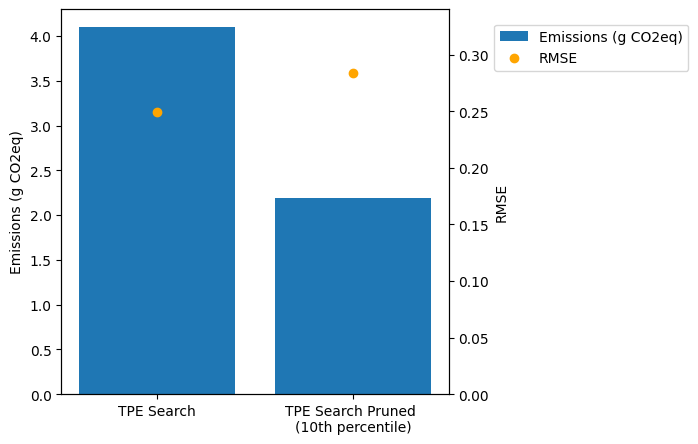

In [ ]:
tuning_results = pd.DataFrame(
    {
        "Category": ["TPE Search", "TPE Search Pruned \n(10th percentile)"],
        "RMSE": [
            tpe_search_study.best_value,
            tpe_search_10perc_pruned_study.best_value,
        ],
        "Emissions": [
            tpe_search_emissions * 1000,
            tpe_search_percentile_pruned_emissions * 1000,
        ],
    }
)

plot_comparison(tuning_results)

The plot shows that our RMSE stayed essentially constant but we significantly reduced our emissions just by implementing a 10th percentile pruner. Not bad!

### Exercise 3
⭐ **YOUR TURN!:** Experiment with pruning using the `MedianPruner`. How does this change affect the number of trials pruned? What is the impact on the final emissions and model performance?

In [ ]:
experiment_name = "tpe_search_median_pruned"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

In [ ]:
# Part 1: Use 5 start-up trials for both the TPE Sampler and the Median Pruner
tpe_search_median_pruned_study = optuna.create_study(
    ### YOUR CODE HERE ###
)
tpe_search_median_pruned_study.optimize(
    objective_with_pruning, n_trials=12, show_progress_bar=True
)

In [ ]:
tpe_search_median_pruned_emissions = tracker.stop()
print(
    f"Emissions from this training run: {tpe_search_median_pruned_emissions:.5f} kg CO2eq"
)

In [ ]:
df = pd.DataFrame(
    {
        "strategy": ["Not pruned", "Pruned: 10th Percentile", "Pruned: Median"],
        "num_input_time_steps": [
            tpe_search_study.best_params["num_input_time_steps"],
            tpe_search_10perc_pruned_study.best_params["num_input_time_steps"],
            tpe_search_median_pruned_study.best_params["num_input_time_steps"],

        ],
        "learning_rate": [
            tpe_search_study.best_params["learning_rate"],
            tpe_search_10perc_pruned_study.best_params["learning_rate"],
            tpe_search_median_pruned_study.best_params["learning_rate"],

        ],
        "optimizer": [
            tpe_search_study.best_params["optimizer"],
            tpe_search_10perc_pruned_study.best_params["optimizer"],
            tpe_search_median_pruned_study.best_params["optimizer"],

        ],
        "RMSE": [
            tpe_search_study.best_value,
            tpe_search_10perc_pruned_study.best_value,
            tpe_search_median_pruned_study.best_value,
        ],
        "Emissions": [
            tpe_search_emissions,
            tpe_search_percentile_pruned_emissions,
            tpe_search_median_pruned_emissions,
        ],
    }
)

df.set_index("strategy")

#### Solution

In [ ]:
# Part 1
tpe_search_median_pruned_study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(n_startup_trials=5, seed=0),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5),
)

Fewer trials are pruned resulting in slightly higher emissions than the 10th percentile pruning strategy. The median pruning strategy found nearly the same optimal hyperparameters (and resulting RMSE) as when we didn't prune.

## **3.4 Other Exercises (Optional)**

Algorithm choice and hyperparameter tuning are just two strategies to reduce your emissions from training an ML model. If you'd like to continue to experiment, check out these optional challenge exercises!

* **Adjust your underlying hardware:** Click on "Runtime" at the top of this notebook and select "Change runtime type." Select "None" to switch to a runtime without any GPU's. Execute the entire notebook again and note how the emissions differ now that we're relying on CPU's to execute our ML training. Which type of models are most affected by this switch? If you have access to a Colab Pro account, try upgrading instead to a premium GPU class. How does access to faster GPU's affect the energy consumed by our code?
* **Adjust your compute region:** Click on "Runtime" at the top of this notebook and select "Disconnect and delete runtime." Execute the first two sections until you connect to a new compute region with a different energy intensity.




# **References**
[1] Kaack, L.H., Donti, P.L., Strubell, E. et al. "Aligning artificial intelligence with climate change mitigation." Nat. Clim. Chang. 12, 518–527 (2022). https://doi.org/10.1038/s41558-022-01377-7

[2] Oil in the Cloud: How Tech Companies are Helping Big Oil Profit from Climate Destruction (Greenpeace, 2019); https://www.greenpeace.org/usa/reports/oil-in-the-cloud/

[3] AI-Based Smart Farming: The Rise of Machine Learning in Livestock Farming (Nexocode, 2022); https://nexocode.com/blog/posts/ai-based-smart-farming-machine-learning-in-livestock-farming/

[4]  Dario Amodei and Daniel Hernandez. 2018. AI and Compute. https://openai.com/blog/ai-and-compute/

[5] Patterson, David A. et al. “The Carbon Footprint of Machine Learning Training Will Plateau, Then Shrink.” Computer 55 (2022): 18-28.

[6] Budennyy, Semen A. et al. “eco2AI: Carbon Emissions Tracking of Machine Learning Models as the First Step Towards Sustainable AI.” Doklady Mathematics 106 (2022): S118 - S128.

[7] Wu, Carole-Jean et al. "Sustainable AI: Environmental Implications, Challenges and Opportunities." Proceedings of the 5th MLSys Conference, Santa Clara, CA, USA, 2022.

[8] Jiang, A. H. et al. Accelerating deep learning by focusing on the biggest losers. Preprint at https://arxiv.org/abs/1910.00762 (2019)

[9] ChatGPT reaches 100 million users two months after launch (The Guardian, 2023); https://www.theguardian.com/technology/2023/feb/02/chatgpt-100-million-users-open-ai-fastest-growing-app

[10] How much electricity does an American home use? (U.S. Energy Information Administration, 2022); https://www.eia.gov/tools/faqs/faq.php?id=97&t=3#

[11] Lannelongue, L., Grealey, J., Inouye, M. "Green Algorithms: Quantifying the carbon footprint of computation." Advanced Science 8(12), 2021. https://doi.org/10.1002/advs.202100707

